In [1]:
import numpy as np
import pandas as pd

from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
%matplotlib inline

import itertools
import scipy
from scipy.stats import chi2_contingency
import collections
import sklearn
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures

# import seaborn as sns
# sns.set()

In [25]:
def plot_confusion_matrix(cm, classes, title, cmap=plt.cm.Blues):
    plt.figure(figsize =(15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    

## Load raw data

In [2]:
df = pd.read_csv('covtype.data', header=None)
print(df.shape)
df.head()

(581012, 55)


,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


## Convert binary columns into categorical

In [3]:
Wilderness_Area = df.iloc[:, 10:13+1].copy()
Soil_Type = df.iloc[:, 14:53+1].copy()

In [4]:
df = df.drop(np.arange(10, 13+1), axis=1)
df = df.drop(np.arange(14, 53+1), axis=1)
df.columns = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Cover_Type']

In [5]:
df['Wilderness_Area'] = Wilderness_Area.idxmax(axis=1) - 10 + 1
df['Soil_Type'] = Soil_Type.idxmax(axis=1) - 14 + 1
print(df.shape)
df.head()


(581012, 13)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type,Wilderness_Area,Soil_Type
0,2596,51,3,258,0,510,221,232,148,6279,5,1,29
1,2590,56,2,212,-6,390,220,235,151,6225,5,1,29
2,2804,139,9,268,65,3180,234,238,135,6121,2,1,12
3,2785,155,18,242,118,3090,238,238,122,6211,2,1,30
4,2595,45,2,153,-1,391,220,234,150,6172,5,1,29


In [6]:
df.to_csv('processed/covtype_categorical.csv', index=False, header=True)

In [7]:
df = pd.read_csv('processed/covtype_categorical.csv')
print(df.shape)
df.head()

(581012, 13)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type,Wilderness_Area,Soil_Type
0,2596,51,3,258,0,510,221,232,148,6279,5,1,29
1,2590,56,2,212,-6,390,220,235,151,6225,5,1,29
2,2804,139,9,268,65,3180,234,238,135,6121,2,1,12
3,2785,155,18,242,118,3090,238,238,122,6211,2,1,30
4,2595,45,2,153,-1,391,220,234,150,6172,5,1,29


## Missing values
The following metrics are calculted for the entire dataset. This includes the last three columns which are categorical.

In [9]:
pd.DataFrame(df.isnull().sum())

,0
Elevation,0
Aspect,0
Slope,0
Horizontal_Distance_To_Hydrology,0
Vertical_Distance_To_Hydrology,0
Horizontal_Distance_To_Roadways,0
Hillshade_9am,0
Hillshade_Noon,0
Hillshade_3pm,0
Horizontal_Distance_To_Fire_Points,0


In [20]:
pd.DataFrame(df.min())

,0
Elevation,1859
Aspect,0
Slope,0
Horizontal_Distance_To_Hydrology,0
Vertical_Distance_To_Hydrology,-173
Horizontal_Distance_To_Roadways,0
Hillshade_9am,0
Hillshade_Noon,0
Hillshade_3pm,0
Horizontal_Distance_To_Fire_Points,0


In [21]:
pd.DataFrame(df.max())

,0
Elevation,3858
Aspect,360
Slope,66
Horizontal_Distance_To_Hydrology,1397
Vertical_Distance_To_Hydrology,601
Horizontal_Distance_To_Roadways,7117
Hillshade_9am,254
Hillshade_Noon,254
Hillshade_3pm,254
Horizontal_Distance_To_Fire_Points,7173


## Change datatypes for efficiency

In [166]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 13 columns):
Elevation                             581012 non-null int64
Aspect                                581012 non-null int64
Slope                                 581012 non-null int64
Horizontal_Distance_To_Hydrology      581012 non-null int64
Vertical_Distance_To_Hydrology        581012 non-null int64
Horizontal_Distance_To_Roadways       581012 non-null int64
Hillshade_9am                         581012 non-null int64
Hillshade_Noon                        581012 non-null int64
Hillshade_3pm                         581012 non-null int64
Horizontal_Distance_To_Fire_Points    581012 non-null int64
Cover_Type                            581012 non-null int64
Wilderness_Area                       581012 non-null int64
Soil_Type                             581012 non-null int64
dtypes: int64(13)
memory usage: 57.6 MB


In [8]:
df['Elevation'] = df['Elevation'].astype('uint16')
df['Aspect'] = df['Aspect'].astype('uint16')
df['Slope'] = df['Slope'].astype('uint8')
df['Horizontal_Distance_To_Hydrology'] = df['Horizontal_Distance_To_Hydrology'].astype('uint16')
df['Vertical_Distance_To_Hydrology'] = df['Vertical_Distance_To_Hydrology'].astype('int16')
df['Horizontal_Distance_To_Roadways'] = df['Horizontal_Distance_To_Roadways'].astype('uint32')
df['Hillshade_9am'] = df['Hillshade_9am'].astype('uint16')
df['Hillshade_Noon'] = df['Hillshade_Noon'].astype('uint16')
df['Hillshade_3pm'] = df['Hillshade_3pm'].astype('uint16')
df['Horizontal_Distance_To_Fire_Points'] = df['Horizontal_Distance_To_Fire_Points'].astype('uint32')
df['Cover_Type'] = df['Cover_Type'].astype('uint8')
df['Wilderness_Area'] = df['Wilderness_Area'].astype('uint8')
df['Soil_Type'] = df['Soil_Type'].astype('uint8')

In [77]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 13 columns):
Elevation                             581012 non-null uint16
Aspect                                581012 non-null uint16
Slope                                 581012 non-null uint8
Horizontal_Distance_To_Hydrology      581012 non-null uint16
Vertical_Distance_To_Hydrology        581012 non-null int16
Horizontal_Distance_To_Roadways       581012 non-null uint32
Hillshade_9am                         581012 non-null uint16
Hillshade_Noon                        581012 non-null uint16
Hillshade_3pm                         581012 non-null uint16
Horizontal_Distance_To_Fire_Points    581012 non-null uint32
Cover_Type                            581012 non-null uint8
Wilderness_Area                       581012 non-null uint8
Soil_Type                             581012 non-null uint8
dtypes: int16(1), uint16(6), uint32(2), uint8(4)
memory usage: 14.4 MB


In [9]:
df.to_csv('processed/covtype_categorical_small.csv', index=False, header=True)


In [10]:
df = pd.read_csv('processed/covtype_categorical_small.csv')
print(df.shape)
df.head()

(581012, 13)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type,Wilderness_Area,Soil_Type
0,2596,51,3,258,0,510,221,232,148,6279,5,1,29
1,2590,56,2,212,-6,390,220,235,151,6225,5,1,29
2,2804,139,9,268,65,3180,234,238,135,6121,2,1,12
3,2785,155,18,242,118,3090,238,238,122,6211,2,1,30
4,2595,45,2,153,-1,391,220,234,150,6172,5,1,29


## Column-wise plots

The following plots are generated for the entire dataset. This includes the last three columns which are categorical.

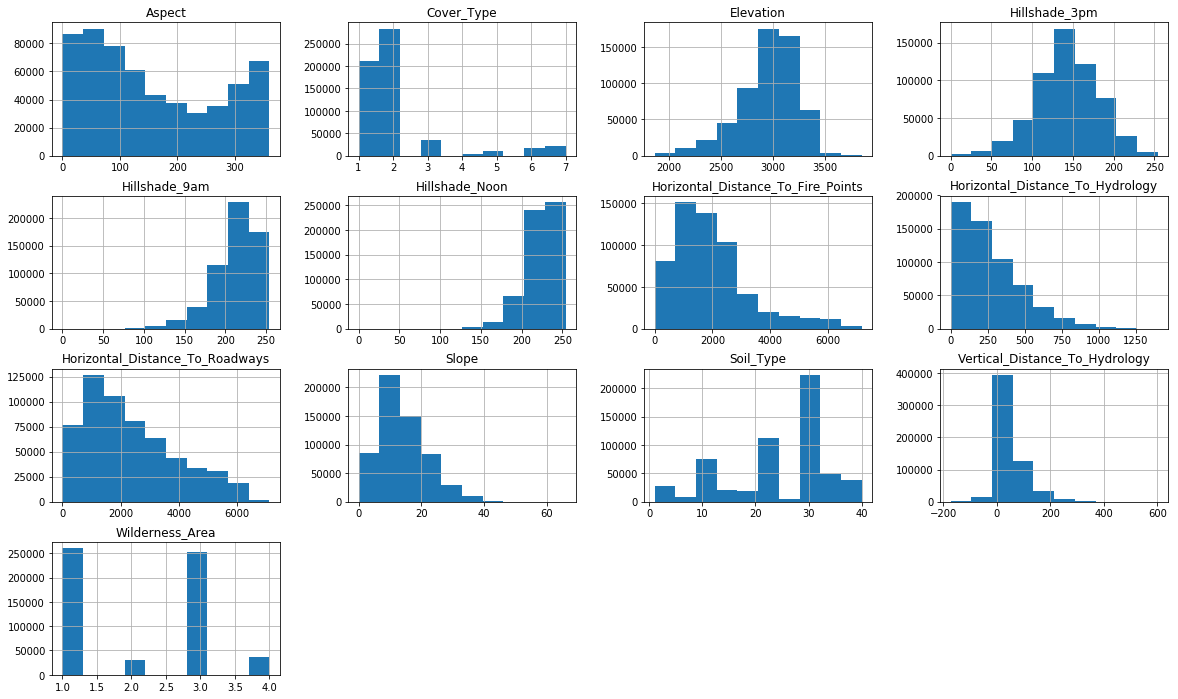

In [13]:
df.hist(figsize=(20, 12))
plt.show()

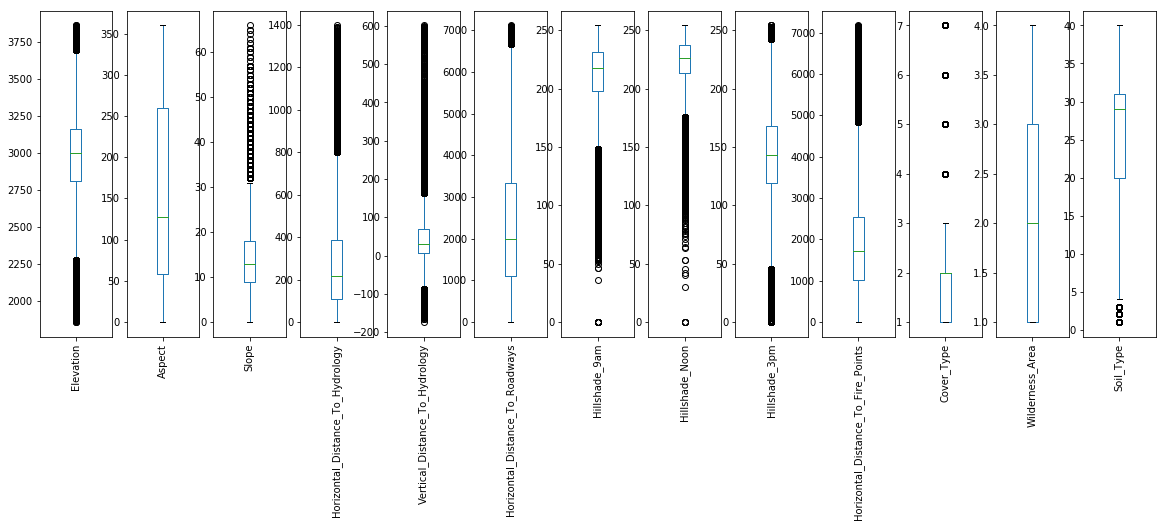

In [13]:
df.plot(kind='box', figsize=(20, 6), rot=90, subplots=True)
plt.show()

In [ ]:
df.plot(kind='bar', figsize=(20, 6), rot=90, subplots=True)
plt.show()

In [ ]:
df.plot(kind='scatter', figsize=(20, 6), rot=90, subplots=True)
plt.show()

In [ ]:
df.plot(kind='pie', figsize=(20, 6), rot=90, subplots=True)
plt.show()

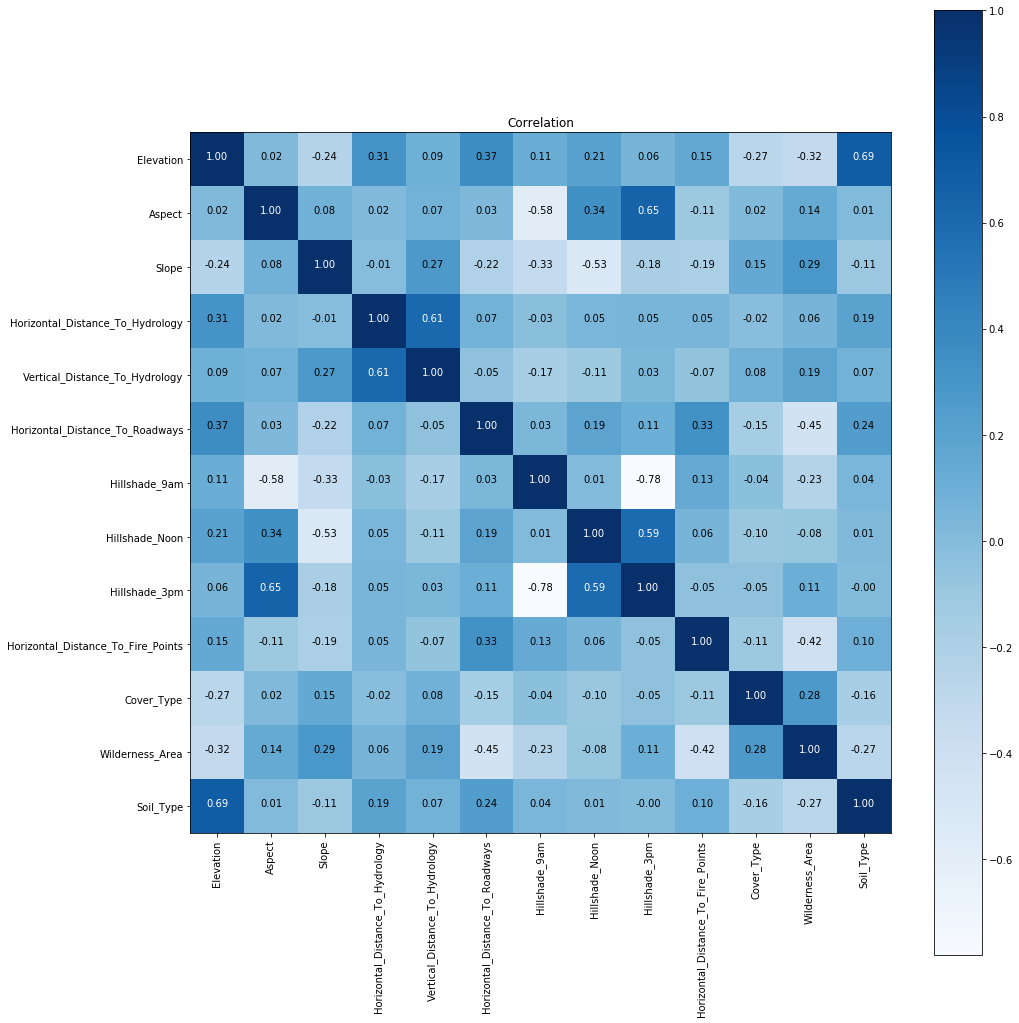

In [20]:
plot_confusion_matrix(df.corr().as_matrix(), classes=df.columns, title='Correlation')

In [ ]:
scatter_matrix(df, alpha=0.2, figsize=(20, 20))
plt.show()

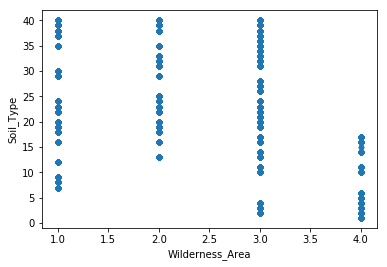

In [54]:
df.plot(kind='scatter', x='Wilderness_Area', y='Soil_Type')
plt.show()

# Chi-Square

In [55]:
table = pd.crosstab(df['Wilderness_Area'],df['Soil_Type']) 
chi2,p,dof,expected=chi2_contingency(table.values)
print(chi2)
print(dof)
print(p)                       
                       

819289.809223
117
0.0


# Pearson correlation coefficient

In [49]:
d = collections.defaultdict(list)
for column_1 in df:
    index = df.columns.get_loc(column_1)
    for column_2 in df:
        if (df.columns.get_loc(column_2) == index):
            continue
        pearson_coefficient = scipy.stats.pearsonr(df[column_1],df[column_2])    
        d[column_1 + "," + column_2].append( pearson_coefficient) 

defaultdict(list,
            {'Aspect,Cover_Type': [(0.017079802032774309,
               9.4350688374852608e-39)],
             'Aspect,Elevation': [(0.015734938290299583,
               3.7952628201407437e-33)],
             'Aspect,Hillshade_3pm': [(0.64694395349569112, 0.0)],
             'Aspect,Hillshade_9am': [(-0.57927291094052202, 0.0)],
             'Aspect,Hillshade_Noon': [(0.33610296426695507, 0.0)],
             'Aspect,Horizontal_Distance_To_Fire_Points': [(-0.10917150103628813,
               0.0)],
             'Aspect,Horizontal_Distance_To_Hydrology': [(0.017376004241803081,
               4.7792215298433301e-40)],
             'Aspect,Horizontal_Distance_To_Roadways': [(0.025120691297270042,
               9.4923400237403341e-82)],
             'Aspect,Slope': [(0.078728410335498086, 0.0)],
             'Aspect,Soil_Type': [(0.0071487513444321651,
               5.0616136365115873e-08)],
             'Aspect,Vertical_Distance_To_Hydrology': [(0.070305123797530761,


In [58]:
d1 = collections.defaultdict(list)
for column_1 in df:
    index = df.columns.get_loc(column_1)
    for column_2 in df:
        if (df.columns.get_loc(column_2) == index):
            continue
        spearman_coefficient = scipy.stats.spearmanr(df[column_1],df[column_2])  
        d1[column_1 + "," + column_2].append(spearman_coefficient) 


In [59]:
d1


defaultdict(list,
            {'Aspect,Cover_Type': [SpearmanrResult(correlation=0.025320091970269042, pvalue=5.0605164868895987e-83)],
             'Aspect,Elevation': [SpearmanrResult(correlation=0.044060248759691695, pvalue=1.6334605738593911e-247)],
             'Aspect,Hillshade_3pm': [SpearmanrResult(correlation=0.64053596530430479, pvalue=0.0)],
             'Aspect,Hillshade_9am': [SpearmanrResult(correlation=-0.4289569342722297, pvalue=0.0)],
             'Aspect,Hillshade_Noon': [SpearmanrResult(correlation=0.42113353597990694, pvalue=0.0)],
             'Aspect,Horizontal_Distance_To_Fire_Points': [SpearmanrResult(correlation=-0.11272388108377185, pvalue=0.0)],
             'Aspect,Horizontal_Distance_To_Hydrology': [SpearmanrResult(correlation=0.0046922591837538098, pvalue=0.00034803050637731376)],
             'Aspect,Horizontal_Distance_To_Roadways': [SpearmanrResult(correlation=0.019417535169200906, pvalue=1.4174053950743282e-49)],
             'Aspect,Slope': [Spearmanr

In [60]:
d

defaultdict(list,
            {'Aspect,Cover_Type': [(0.017079802032774309,
               9.4350688374852608e-39)],
             'Aspect,Elevation': [(0.015734938290299583,
               3.7952628201407437e-33)],
             'Aspect,Hillshade_3pm': [(0.64694395349569112, 0.0)],
             'Aspect,Hillshade_9am': [(-0.57927291094052202, 0.0)],
             'Aspect,Hillshade_Noon': [(0.33610296426695507, 0.0)],
             'Aspect,Horizontal_Distance_To_Fire_Points': [(-0.10917150103628813,
               0.0)],
             'Aspect,Horizontal_Distance_To_Hydrology': [(0.017376004241803081,
               4.7792215298433301e-40)],
             'Aspect,Horizontal_Distance_To_Roadways': [(0.025120691297270042,
               9.4923400237403341e-82)],
             'Aspect,Slope': [(0.078728410335498086, 0.0)],
             'Aspect,Soil_Type': [(0.0071487513444321651,
               5.0616136365115873e-08)],
             'Aspect,Vertical_Distance_To_Hydrology': [(0.070305123797530761,


# Five Number Summary
     

In [37]:
summary = collections.defaultdict(list)
for column in df:
    low = df[column].min()
    high = df[column].max()
    quartiles = df[column].quantile([0.25,0.5,0.75])
    summary[column].append(low)
    summary[column].append(high)
    summary[column].append(quartiles)
    

# Log Transformation of skewed data


In [11]:
df['Slope'] = np.log((1+ df['Slope']))
df['Hillshade_9am'] = np.log((1+ df['Hillshade_9am']))
df['Hillshade_Noon'] = np.log((1+ df['Hillshade_Noon']))
df['Horizontal_Distance_To_Fire_Points'] = np.log((1+ df['Horizontal_Distance_To_Fire_Points']))
df['Horizontal_Distance_To_Hydrology'] = np.log((1+ df['Horizontal_Distance_To_Hydrology']))

In [12]:
def log_transform_visualize(column):
    column_log_mean = np.round(np.mean(df['Slope']), 2)
    fig, ax = plt.subplots()
    df[column].hist(bins=30, color='#A9C5D3',edgecolor='black', grid=False)
    plt.axvline(column_log_mean, color='r')
    ax.set_title('Histogram after Log Transform', fontsize=12)
    ax.set_xlabel(column, fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.text(11.5, 450, r'$\mu$='+str(column_log_mean), fontsize=10)
    



# Quantile based binning

In [13]:
def binning_plot(column):
    fig, ax = plt.subplots()
    df[column].hist(bins=30, color='#A9C5D3', 
                             edgecolor='black', grid=False)
    ax.set_title('Histogram', fontsize=12)
    ax.set_xlabel(column, fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    quantile_list = [0, .10, .20, .30, .40 , .50, .60, .70, .80, .90, 1.0]
    quantiles = df[column].quantile(quantile_list)
    # PLOT
    fig, ax = plt.subplots()
    df[column].hist(bins=30, color='#A9C5D3', 
                                 edgecolor='black', grid=False)
    for quantile in quantiles:
        qvl = plt.axvline(quantile, color='r')
    ax.legend([qvl], ['Quantiles'], fontsize=10)
    ax.set_title('Quantiles', 
                 fontsize=12)
    ax.set_xlabel(column, fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)

In [14]:
quantile_labels = ['1', '2', '3', '4', '5','6','7','8','9','10']
quantile_list = [0, .10, .20, .30, .40 , .50, .60, .70, .80, .90, 1.0]
# df['Slope_quantile_range'] = pd.qcut(df['Slope'], q=quantile_list)  
df['Slope'] = pd.qcut(df['Slope'],  q=quantile_list, labels=quantile_labels)
df['Elevation'] = pd.qcut(df['Elevation'],  q=quantile_list, labels=quantile_labels)
df['Horizontal_Distance_To_Hydrology'] = pd.qcut(df['Horizontal_Distance_To_Hydrology'],  q=quantile_list, labels=quantile_labels)
df['Vertical_Distance_To_Hydrology'] = pd.qcut(df['Vertical_Distance_To_Hydrology'],  q=quantile_list, labels=quantile_labels)
df['Horizontal_Distance_To_Roadways'] = pd.qcut(df['Horizontal_Distance_To_Roadways'],  q=quantile_list, labels=quantile_labels)
df['Horizontal_Distance_To_Fire_Points'] = pd.qcut(df['Horizontal_Distance_To_Fire_Points'],  q=quantile_list, labels=quantile_labels)
df['Aspect'] = pd.qcut(df['Aspect'],  q=quantile_list, labels=quantile_labels)
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type,Wilderness_Area,Soil_Type
0,2,3,1,6,1,1,5.402677,5.451038,148,10,5,1,29
1,2,3,1,5,1,1,5.398163,5.463832,151,10,5,1,29
2,3,6,3,6,8,8,5.459586,5.476464,135,10,2,1,12
3,3,6,8,6,9,8,5.476464,5.476464,122,10,2,1,30
4,2,2,1,4,1,1,5.398163,5.459586,150,10,5,1,29


In [15]:
def hist(column):
    fig, ax = plt.subplots()
    df[column].hist(bins=10, color='#A9C5D3', edgecolor='black', grid=False)
    ax.set_title('Histogram', fontsize=12)
    ax.set_xlabel(column, fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    
# for column in df:
#     hist(column)

In [16]:
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type,Wilderness_Area,Soil_Type
0,2,3,1,6,1,1,5.402677,5.451038,148,10,5,1,29
1,2,3,1,5,1,1,5.398163,5.463832,151,10,5,1,29
2,3,6,3,6,8,8,5.459586,5.476464,135,10,2,1,12
3,3,6,8,6,9,8,5.476464,5.476464,122,10,2,1,30
4,2,2,1,4,1,1,5.398163,5.459586,150,10,5,1,29


# Feature Engineering

In [17]:
features = np.array(['Elevation','Aspect', 'Slope','Horizontal_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways','Hillshade_9am', 
                     'Hillshade_Noon', 'Hillshade_3pm',
                     'Horizontal_Distance_To_Fire_Points','Wilderness_Area','Soil_Type'])
clf = RandomForestClassifier()
clf.fit(df[features], df['Cover_Type'])


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

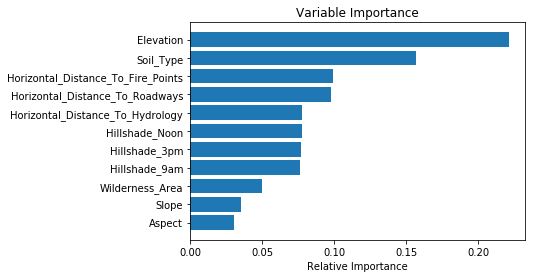

In [18]:
# Sort them from most to least important
importances = clf.feature_importances_
sorted_idx = np.argsort(importances)
# Bar plot
padding = np.arange(len(features)) + 0.5
plt.barh(padding, importances[sorted_idx], align='center')
plt.yticks(padding, features[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()

In [19]:
def generate_feature(feature_1,feature_2):
    new_def = df[[feature_1,feature_2]]
    pf = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    res = pf.fit_transform(new_def)
    return res
   

In [20]:
new_features_1 = pd.DataFrame(generate_feature('Elevation','Soil_Type'), columns=[ 'Elevation^2', 'Elevation_Soil_Type','Soil_Type^2'])
new_features_2 = pd.DataFrame(generate_feature('Elevation','Horizontal_Distance_To_Fire_Points'), columns=[ 'Elevation^2', 'Elevation_Horizontal_Distance_Fire','Horizontal_Distance_To_Fire_Points^2'])
new_features_3 = pd.DataFrame(generate_feature('Horizontal_Distance_To_Fire_Points','Soil_Type'), columns=[ 'Horizontal_Distance_To_Fire_Points^2', 'Horizontal_Distance_Fire_Soil_Type','Soil_Type^2'])


In [21]:
df['Elevation_Soil_Type'] = new_features_1['Elevation_Soil_Type']
df['Elevation_Horizontal_Distance_Fire'] = new_features_2['Elevation_Horizontal_Distance_Fire']
df['Horizontal_Distance_Fire_Soil_Type'] = new_features_3['Horizontal_Distance_Fire_Soil_Type']
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type,Wilderness_Area,Soil_Type,Elevation_Soil_Type,Elevation_Horizontal_Distance_Fire,Horizontal_Distance_Fire_Soil_Type
0,2,3,1,6,1,1,5.402677,5.451038,148,10,5,1,29,29.0,10.0,29.0
1,2,3,1,5,1,1,5.398163,5.463832,151,10,5,1,29,29.0,10.0,29.0
2,3,6,3,6,8,8,5.459586,5.476464,135,10,2,1,12,12.0,10.0,12.0
3,3,6,8,6,9,8,5.476464,5.476464,122,10,2,1,30,30.0,10.0,30.0
4,2,2,1,4,1,1,5.398163,5.459586,150,10,5,1,29,29.0,10.0,29.0


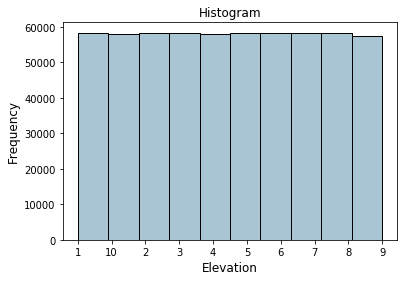

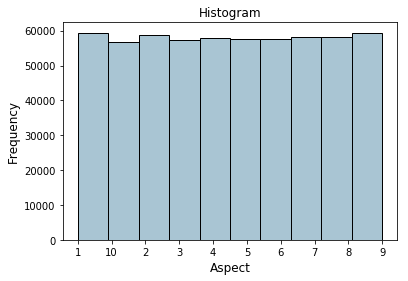

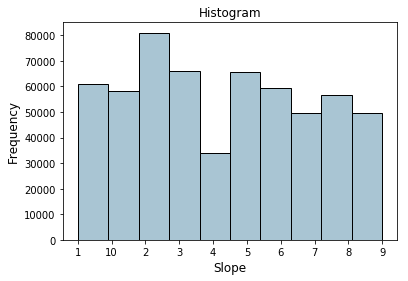

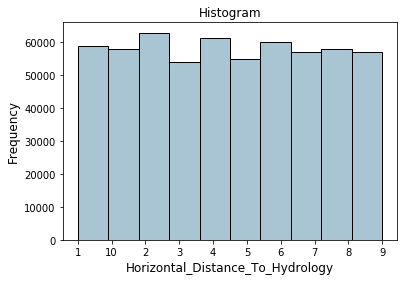

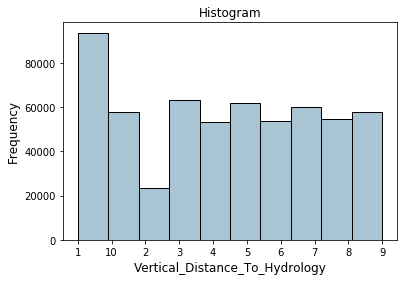

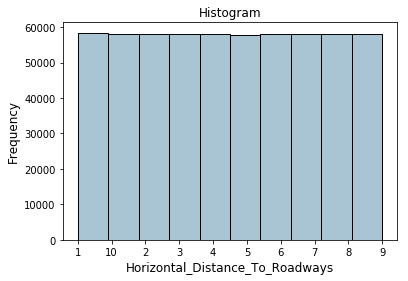

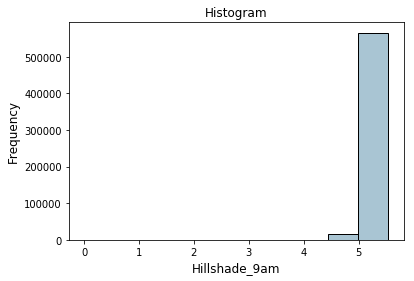

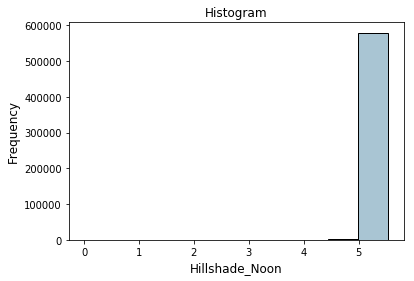

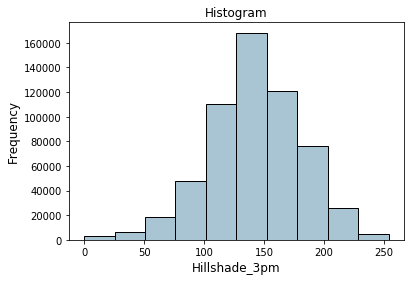

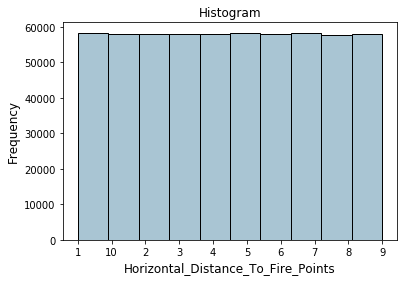

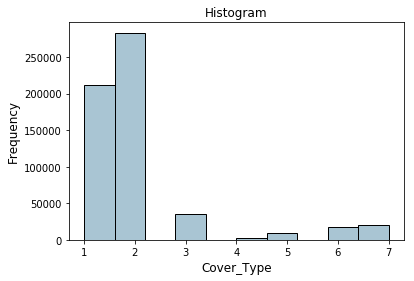

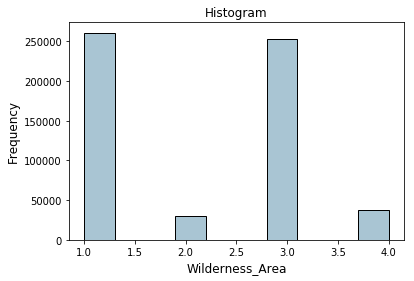

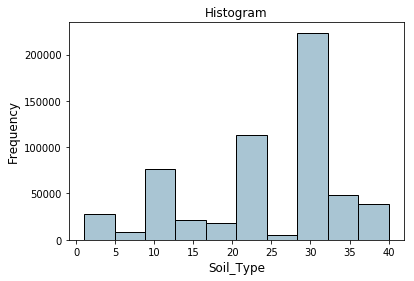

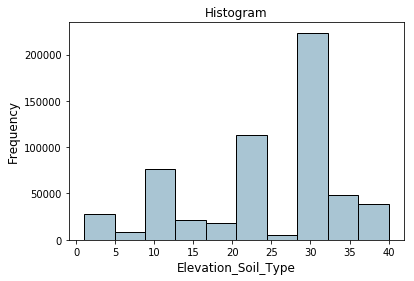

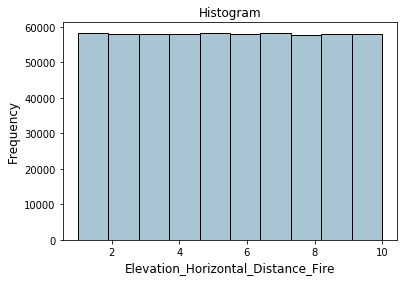

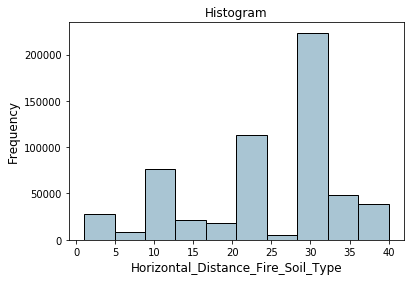

In [22]:
# for column in df:
#     hist(column)